In [1]:
from functools import lru_cache
import dtreeviz.trees as dtreeviz
import graphviz
import ipywidgets as widgets
import numpy as np
import seaborn as sns
import pandas as pd
from IPython.display import SVG, display
from ipywidgets import Button, IntSlider, interactive
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn import preprocessing, tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler)
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)
from sklearn.model_selection import StratifiedKFold
sns.set()

from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import DBSCAN


In [2]:
from preprocessing import obtener_datasets
from preprocessing import aplicar_preparacion
from preprocessing import conversion_numerica
from preprocessing import plot_roc_curves
from preprocessing import graficar_matriz_confusion
from preprocessing import get_dataframe_polynomial_all
from preprocessing import reduccion_rfecv
from preprocessing import aplicar_preparacion_generalizado
from preprocessing import conversion_numerica_generalizada

In [3]:
df_, df_for_prediction = obtener_datasets()
X_df, y_df = aplicar_preparacion(df_)

# Introducción
https://scikit-learn.org/stable/modules/naive_bayes.html

Laburaremos con el modelo de **Naive Bayes**, se conocen 3 diferentes formas de implementar: 
* Cuando trabajamos con features continuos -> (GaussianNB)
* Cuando trabajamos con features discretos -> (MultinomialNB)
* Cuando trabajamos con features categoricos -> (CategoricalNB)

Estaremos utilizando los 3 tipos de tecnicas de Naive Bayes. Esto implica tener que dividir nuestro dataset.

In [4]:
from preprocessing import obtener_features_continuas
from preprocessing import obtener_features_discretas
from preprocessing import get_dataframe_scaled

# GaussianNB

Solo para valores continuos. Es decir nos quedaremos con las 2 columnas numéricas continuas de 'edad' y 'suma_declarada_bolsa_argentina'

In [5]:
X_df.describe()

,anios_estudiados,edad,suma_declarada_bolsa_argentina,horas_trabajo_registradas
count,32561.000000,32561.000000,32561.000000,32561.000000
mean,14.053868,38.581647,990.345014,40.437456
std,2.664488,13.640433,7408.986951,12.347429
min,1.000000,17.000000,-4356.000000,1.000000
25%,13.000000,28.000000,0.000000,40.000000
50%,14.000000,37.000000,0.000000,40.000000
75%,16.000000,48.000000,0.000000,45.000000
max,20.000000,90.000000,99999.000000,99.000000


## Primer Preprocesamiento: obtener_features_continuas()

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    2.3s finished


AUC-ROC score sobre test:  0.7608417722498504
AUC-ROC score sobre train:  0.7643356120777687
Accuracy sobre test:  0.7930293259634577
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
              precision    recall  f1-score   support

  Bajo valor       0.98      0.80      0.88      6061
  Alto valor       0.21      0.74      0.33       452

    accuracy                           0.79      6513
   macro avg       0.60      0.77      0.61      6513
weighted avg       0.92      0.79      0.84      6513



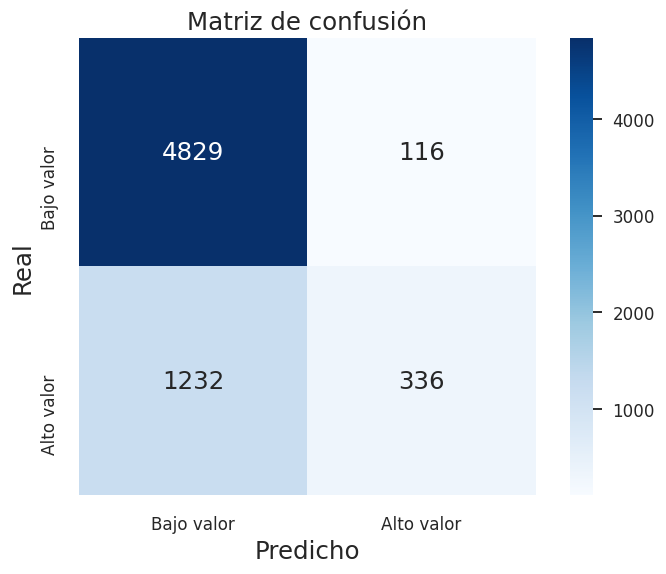

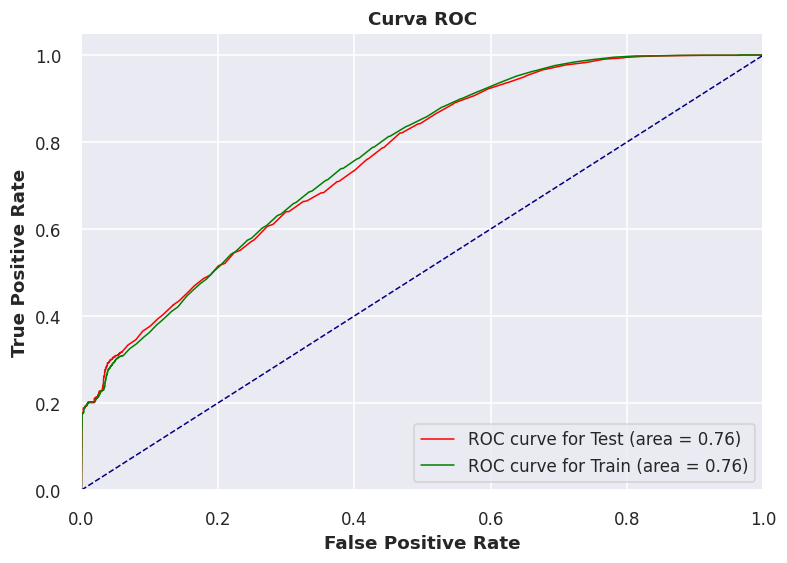

In [6]:
X_df_c = obtener_features_continuas(X_df) 
X_train, X_test, y_train, y_test = train_test_split(X_df_c, y_df, test_size=0.20, random_state=10, stratify=y_df)

params = {
        'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07],
}

clf = GaussianNB()
cv = StratifiedKFold(n_splits=10).split(X_train, y_train)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv, n_jobs = -1, verbose=4)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf, X_test, y_test, X_train, y_train)


Guardamos la prediccion de probabilidad de cada clase para usarlo en un futuro ensamble. Por ahora nos quedamos como mejor preprocesamiento a éste ultimo aplicado.

In [7]:
proba_gauss_train = clf.predict_proba(X_train)
proba_gauss_test = clf.predict_proba(X_test)

## Segundo Preprocesamiento: get_dataframe_polynomial_all()

Acá solamente creamos una funcion que haga lo mismo que la anterior pero realizando solo el preproceasmietno de PolynomialFeatures

In [8]:
    def auc_roc_polynomial(clf_r, XX_df, yy_df, grade, interaction_only, params):
        
        df_poly = get_dataframe_polynomial_all(XX_df, grade, interaction_only)
        X_train, X_test, y_train, y_test = train_test_split(df_poly, yy_df, test_size=0.20, random_state=10, stratify=y_df)        
        
        cv_e = StratifiedKFold(n_splits=10).split(X_train, y_train)
        clf = GridSearchCV(clf_r, params, scoring='roc_auc', cv=cv_e, n_jobs = -1)
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        print(" AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
        print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
        '''
        print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
        print("Los mejores hiperpametros elegidos: ", clf.best_params_)
        print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
        graficar_matriz_confusion(y_test, y_pred)
        plot_roc_curves(clf, X_test, y_test, X_train, y_train)
        '''

* Con PolynomialFeatures(2, interaction_only = True)

In [9]:
X_df_c = obtener_features_continuas(X_df) 
params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
auc_roc_polynomial(GaussianNB(), X_df_c, y_df, 2, True, params)


Dataset inicial con 2 features...
Dataset nuevo con PolynomialFeature con 3 features...
 AUC-ROC score sobre test:  0.7594833345370505
AUC-ROC score sobre train:  0.7625845560902251


* Con PolynomialFeatures(2, interaction_only = False)

In [10]:
X_df_c = obtener_features_continuas(X_df) 
params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
auc_roc_polynomial(GaussianNB(), X_df_c, y_df, 2, False, params)

Dataset inicial con 2 features...
Dataset nuevo con PolynomialFeature con 5 features...
 AUC-ROC score sobre test:  0.7531089432739728
AUC-ROC score sobre train:  0.7576757895042326


* Con PolynomialFeatures(3, interaction_only = True)

In [11]:
X_df_c = obtener_features_continuas(X_df) 
params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
auc_roc_polynomial(GaussianNB(), X_df_c, y_df, 3, True, params)

Dataset inicial con 2 features...
Dataset nuevo con PolynomialFeature con 3 features...
 AUC-ROC score sobre test:  0.7594833345370505
AUC-ROC score sobre train:  0.7625845560902251


* Con PolynomialFeatures(3, interaction_only = False)

In [12]:
X_df_c = obtener_features_continuas(X_df) 
params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
auc_roc_polynomial(GaussianNB(), X_df_c, y_df, 3, False, params)

Dataset inicial con 2 features...
Dataset nuevo con PolynomialFeature con 9 features...
 AUC-ROC score sobre test:  0.7471741451889147
AUC-ROC score sobre train:  0.7507223400188193


## Tercer Preprocesamiento: Scalers

De forma similar a la anterior función, lo haremos solo con los 5 escalados, sin aplicar un PolynomialFeatures. Definamos función:

In [13]:
def auc_scaler(clf_r, XX_df, yy_df, params):
    scalers = [StandardScaler(), MinMaxScaler(), RobustScaler(), PowerTransformer(), Normalizer()]
    for count, scaler in enumerate(scalers):
        print("---------------------------------------------------------------------")
        print("Aplicando preprocesamiento #",count+1, "con scaler de", scaler)
        df_scaled = get_dataframe_scaled(XX_df, scaler)
        X_train, X_test, y_train, y_test = train_test_split(df_scaled, yy_df, test_size=0.20, random_state=10, stratify=y_df)        
        
        cv_e = StratifiedKFold(n_splits=10).split(X_train, y_train)
        clf = GridSearchCV(clf_r, params, scoring='roc_auc', cv=cv_e, n_jobs = -1)
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        print(" AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
        print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
        print("Los mejores hiperpametros elegidos: ", clf.best_params_)
        '''
        print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
        graficar_matriz_confusion(y_test, y_pred)
        print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
        plot_roc_curves(clf, X_test, y_test, X_train, y_train)'''

  

In [14]:
X_df_c = obtener_features_continuas(X_df) 
params =  {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
auc_scaler(GaussianNB(), X_df_c, y_df, params)

---------------------------------------------------------------------
Aplicando preprocesamiento # 1 con scaler de StandardScaler()
 AUC-ROC score sobre test:  0.7608415787953200
AUC-ROC score sobre train:  0.7643349026782453
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
---------------------------------------------------------------------
Aplicando preprocesamiento # 2 con scaler de MinMaxScaler()
 AUC-ROC score sobre test:  0.7608413853407895
AUC-ROC score sobre train:  0.7643346366534238
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
---------------------------------------------------------------------
Aplicando preprocesamiento # 3 con scaler de RobustScaler()
 AUC-ROC score sobre test:  0.7608417722498504
AUC-ROC score sobre train:  0.7643356120777687
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
---------------------------------------------------------------------
Aplicando preprocesamiento # 4 con scaler de PowerTransformer()
 AUC-R

## Eligiendo al mejor: get_dataframe_scaled(PowerTransformer())

In [15]:
X_df_c = obtener_features_continuas(X_df) 
    
df_scaled = get_dataframe_scaled(X_df_c, PowerTransformer())
X_train, X_test, y_train, y_test = train_test_split(df_scaled, y_df, test_size=0.20, random_state=10, stratify=y_df)        
params =  {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
cv_e = StratifiedKFold(n_splits=10).split(X_train, y_train)
clf = GridSearchCV(GaussianNB(), params, scoring='roc_auc', cv=cv_e, n_jobs = -1)
        
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(" AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)


 AUC-ROC score sobre test:  0.7660732341470461
AUC-ROC score sobre train:  0.7672718046136364
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}


In [16]:
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))


Accuracy sobre test:  0.7882696146169200


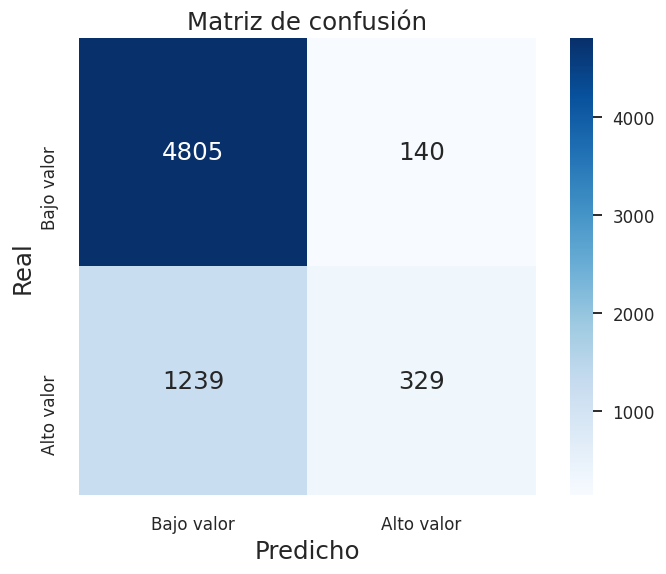

In [17]:
graficar_matriz_confusion(y_test, y_pred)


In [18]:
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))


              precision    recall  f1-score   support

  Bajo valor       0.97      0.80      0.87      6044
  Alto valor       0.21      0.70      0.32       469

    accuracy                           0.79      6513
   macro avg       0.59      0.75      0.60      6513
weighted avg       0.92      0.79      0.83      6513



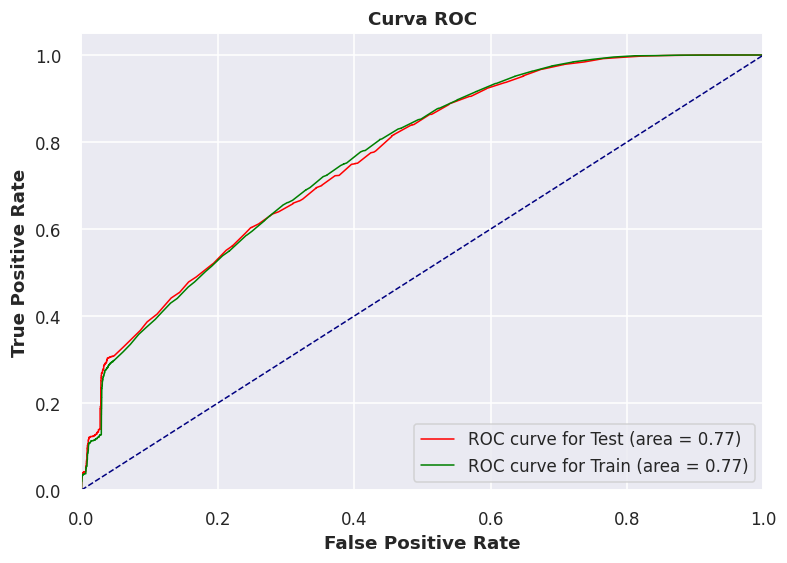

In [19]:
plot_roc_curves(clf, X_test, y_test, X_train, y_train)


In [20]:
proba_gauss_train = clf.predict_proba(X_train)
proba_gauss_test = clf.predict_proba(X_test)

# MultinomialNB

Solo para valores discretos.

Tal como hicimos en el TP1, agrupamos la edad por rangos.

In [21]:
X_df.describe()

,anios_estudiados,edad,suma_declarada_bolsa_argentina,horas_trabajo_registradas
count,32561.000000,32561.000000,32561.000000,32561.000000
mean,14.053868,38.581647,990.345014,40.437456
std,2.664488,13.640433,7408.986951,12.347429
min,1.000000,17.000000,-4356.000000,1.000000
25%,13.000000,28.000000,0.000000,40.000000
50%,14.000000,37.000000,0.000000,40.000000
75%,16.000000,48.000000,0.000000,45.000000
max,20.000000,90.000000,99999.000000,99.000000


## Primer Preprocesamiento: obtener_features_discretas()

In [22]:
X_df_d_n = obtener_features_discretas(X_df)
X_df_d_n

Aplicando 'conversion_numerica' en las variables categóricas.


,edad,anios_estudiados,educacion_alcanzada,suma_declarada_bolsa_argentina,horas_trabajo_registradas,genero_mujer,estado_marital_matrimonio_civil,estado_marital_matrimonio_militar,estado_marital_pareja_no_presente,estado_marital_separado_a,...,categoria_de_trabajo_sin_trabajo,categoria_de_trabajo_trabajo_voluntariado,religion_budismo,religion_cristianismo,religion_judaismo,religion_otro,rol_familiar_registrado_con_hijos,rol_familiar_registrado_otro,rol_familiar_registrado_sin_familia,rol_familiar_registrado_soltero_a
0,3.0,17,5,0.0,2.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,4.0,17,5,0.0,0.0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,2.0,13,4,0.0,2.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,4.0,11,3,0.0,2.0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1.0,17,5,0.0,2.0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,1.0,16,5,0.0,2.0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
32557,3.0,13,4,0.0,2.0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
32558,5.0,13,4,0.0,2.0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
32559,0.0,13,4,0.0,1.0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.6s finished


AUC-ROC score sobre test:  0.8650272255009184
AUC-ROC score sobre train:  0.8678716381868958
Accuracy sobre test:  0.7990173499155535
Los mejores hiperpametros elegidos:  {'alpha': 0.3}
              precision    recall  f1-score   support

  Bajo valor       0.83      0.90      0.86      4602
  Alto valor       0.69      0.57      0.62      1911

    accuracy                           0.80      6513
   macro avg       0.76      0.73      0.74      6513
weighted avg       0.79      0.80      0.79      6513



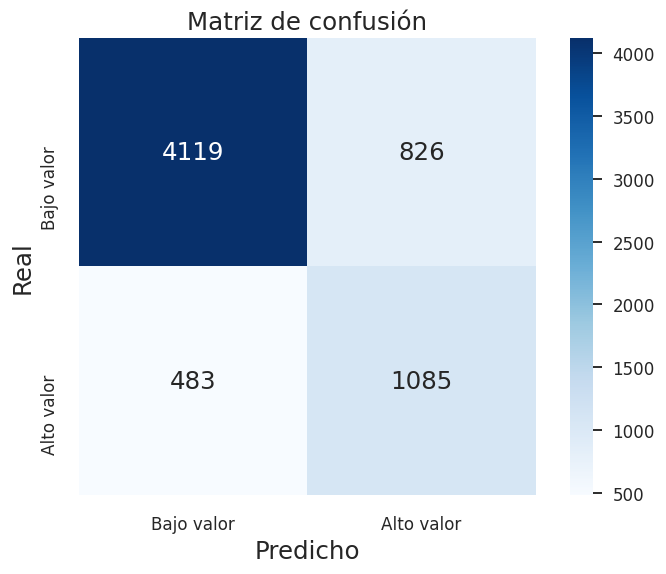

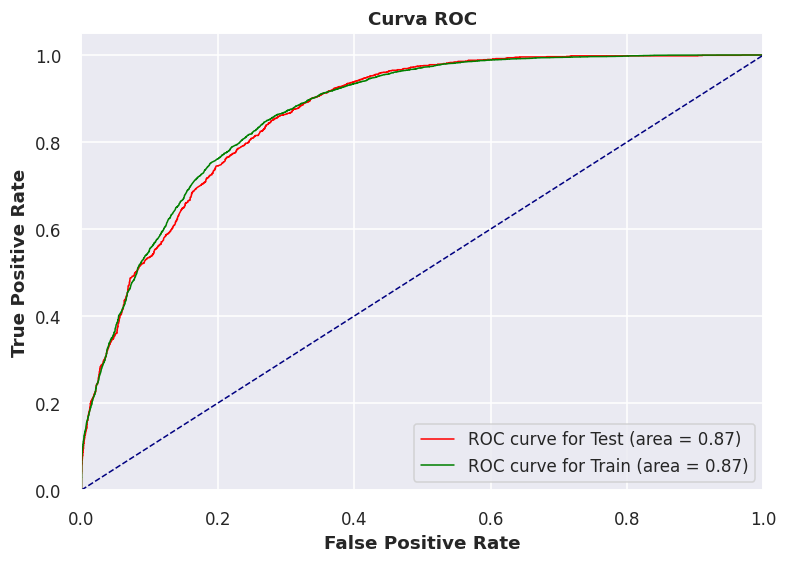

In [23]:
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(X_df_d_n, y_df, test_size=0.20, random_state=10, stratify=y_df)

params = {
        'alpha': [0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1],
}

clf = MultinomialNB()
cv = StratifiedKFold(n_splits=10).split(X_train, y_train)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv, n_jobs = -1, verbose=4)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf, X_test, y_test, X_train, y_train)


In [24]:
proba_multi_train = clf.predict_proba(X_train)
proba_multi_test = clf.predict_proba(X_test)

## Segundo Preprocesamiento: Scalers

Solamente 2 preprocesamientos escalados: MinMaxScaler() y Normalizer(), pues los demás preprocesamientos nos dan valores negativos y MultinomialNB solo trata con valores discretos mayores a cero.

In [25]:
def auc_scaler_no_negative(clf_r, XX_df, yy_df, params):
    scalers = [MinMaxScaler(), Normalizer()]
    for count, scaler in enumerate(scalers):
        print("---------------------------------------------------------------------")
        print("Aplicando preprocesamiento #",count+1, "con scaler de", scaler)
        df_scaled = get_dataframe_scaled(XX_df, scaler)
        X_train, X_test, y_train, y_test = train_test_split(df_scaled, yy_df, test_size=0.20, random_state=10, stratify=y_df)        
        
        cv_e = StratifiedKFold(n_splits=10).split(X_train, y_train)
        clf = GridSearchCV(clf_r, params, scoring='roc_auc', cv=cv_e, n_jobs = -1)
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        print(" AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
        print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
        print("Los mejores hiperpametros elegidos: ", clf.best_params_)
        '''
        print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
        graficar_matriz_confusion(y_test, y_pred)
        print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
        plot_roc_curves(clf, X_test, y_test, X_train, y_train)'''

  

In [26]:
X_df_d = obtener_features_discretas(X_df)
params =  {'alpha': [0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1]}
auc_scaler_no_negative(MultinomialNB(), X_df_d, y_df, params)

Aplicando 'conversion_numerica' en las variables categóricas.
---------------------------------------------------------------------
Aplicando preprocesamiento # 1 con scaler de MinMaxScaler()
 AUC-ROC score sobre test:  0.8563973478673572
AUC-ROC score sobre train:  0.8596401611223669
Los mejores hiperpametros elegidos:  {'alpha': 0.1}
---------------------------------------------------------------------
Aplicando preprocesamiento # 2 con scaler de Normalizer()
 AUC-ROC score sobre test:  0.8544664137141206
AUC-ROC score sobre train:  0.8589477710646816
Los mejores hiperpametros elegidos:  {'alpha': 0.1}


Re ajustamos la funcion pues necesitamos aplicar 'escalados' que no nos den transformaciones negativas.

# CategorialNB

## Primer Preprocesameitno: conversion_numerica()

Aplicando 'conversion_numerica' en las variables categóricas.
Fitting 20 folds for each of 8 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    2.4s finished


AUC-ROC score sobre test:  0.8602924903530673
AUC-ROC score sobre train:  0.8630706398682936
Accuracy sobre test:  0.7813603562106556
Los mejores hiperpametros elegidos:  {'alpha': 0.1}
              precision    recall  f1-score   support

  Bajo valor       0.79      0.91      0.85      4307
  Alto valor       0.75      0.53      0.62      2206

    accuracy                           0.78      6513
   macro avg       0.77      0.72      0.73      6513
weighted avg       0.78      0.78      0.77      6513



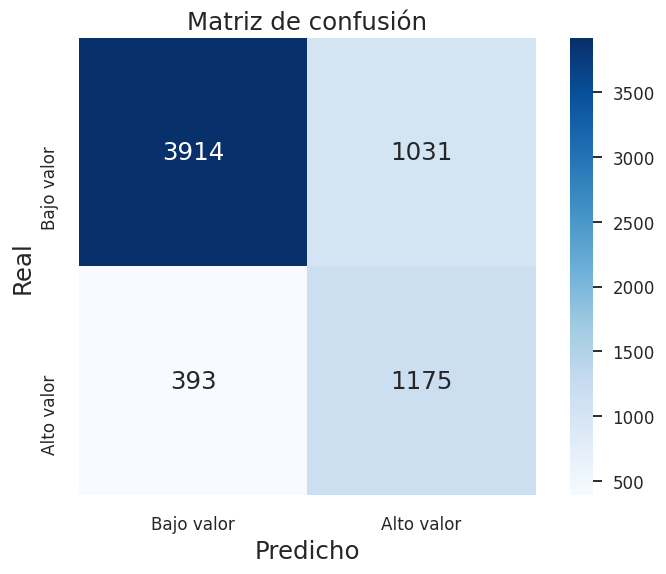

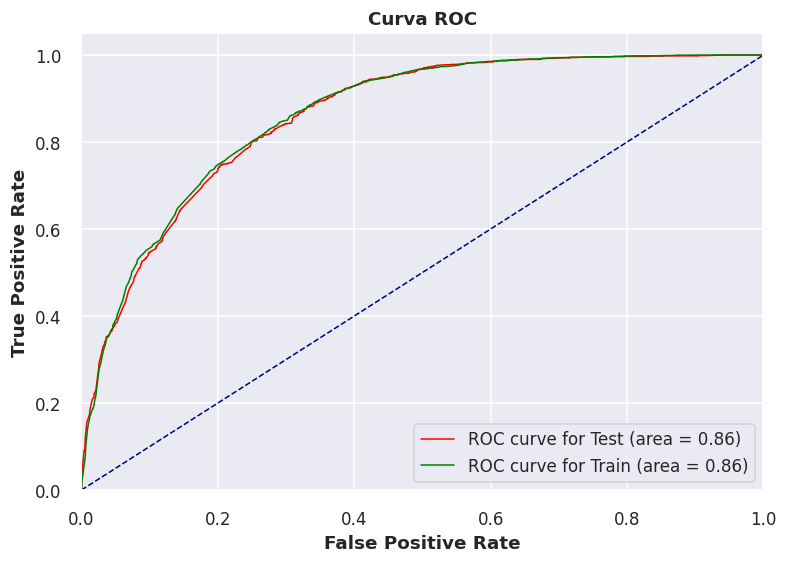

In [27]:
from sklearn.naive_bayes import CategoricalNB
X_df_cat = conversion_numerica(X_df[['categoria_de_trabajo', 'educacion_alcanzada', 'estado_marital', 'genero', 'religion', 'rol_familiar_registrado', 'trabajo']])

X_train, X_test, y_train, y_test = train_test_split(X_df_cat, y_df, test_size=0.20, random_state=10, stratify=y_df)

params = {
        'alpha': [0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1],
}

clf = CategoricalNB()
cv = StratifiedKFold(n_splits=20).split(X_train, y_train)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv, n_jobs = -1, verbose=4)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf, X_test, y_test, X_train, y_train)


## Segundo Preprocesamietno: conversion_numerica_generalizada()

In [28]:
df_, df_for_prediction = obtener_datasets()
X_df, y_df = aplicar_preparacion_generalizado(df_)

In [29]:
X_df_cat = conversion_numerica_generalizada(X_df[['barrio','categoria_de_trabajo', 'educacion_alcanzada', 'estado_marital', 'genero', 'religion', 'rol_familiar_registrado', 'trabajo']])
X_df_cat

Aplicando 'conversion_numerica_generalizada' en las variables categóricas.


,educacion_alcanzada,genero_mujer,estado_marital_matrimonio_civil,estado_marital_matrimonio_militar,estado_marital_pareja_no_presente,estado_marital_separado_a,estado_marital_sin_matrimonio,estado_marital_viudo_a,trabajo_directivo_gerente,trabajo_ejercito,...,categoria_de_trabajo_sin_trabajo,categoria_de_trabajo_trabajo_voluntariado,religion_budismo,religion_cristianismo,religion_judaismo,religion_otro,rol_familiar_registrado_con_hijos,rol_familiar_registrado_otro,rol_familiar_registrado_sin_familia,rol_familiar_registrado_soltero_a
0,13,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,13,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,8,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,6,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,13,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,12,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
32557,8,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
32558,8,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
32559,8,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0


Fitting 20 folds for each of 8 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    3.7s finished


AUC-ROC score sobre test:  0.8627908911289490
AUC-ROC score sobre train:  0.8652470171463074
Accuracy sobre test:  0.7799785045294028
Los mejores hiperpametros elegidos:  {'alpha': 0.1}
              precision    recall  f1-score   support

  Bajo valor       0.79      0.91      0.85      4308
  Alto valor       0.75      0.53      0.62      2205

    accuracy                           0.78      6513
   macro avg       0.77      0.72      0.73      6513
weighted avg       0.78      0.78      0.77      6513



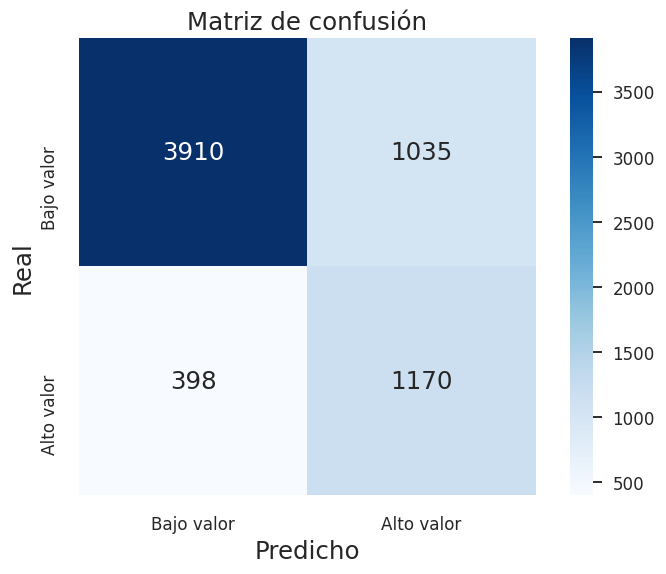

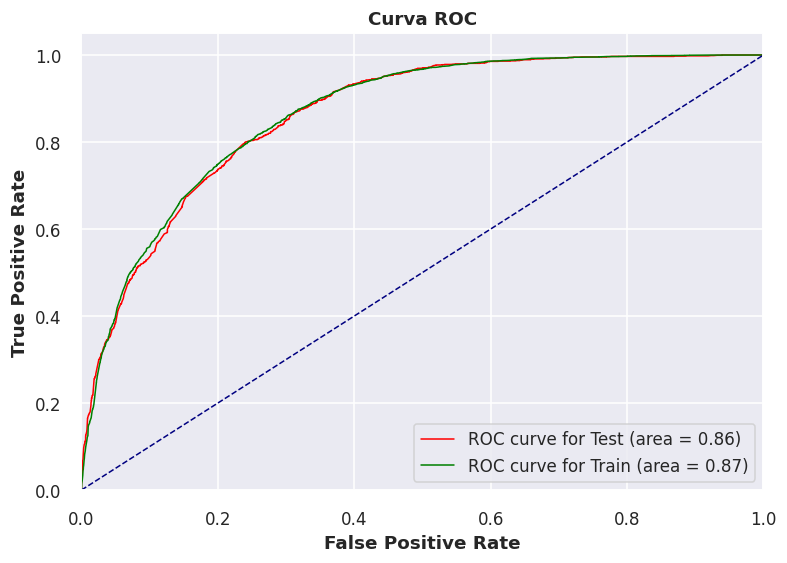

In [30]:
from sklearn.naive_bayes import CategoricalNB

X_train, X_test, y_train, y_test = train_test_split(X_df_cat, y_df, test_size=0.20, random_state=10, stratify=y_df)

params = {
        'alpha': [0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1],
}

clf = CategoricalNB()
cv = StratifiedKFold(n_splits=20).split(X_train, y_train)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv, n_jobs = -1, verbose=4)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf, X_test, y_test, X_train, y_train)


## Eligiendo al mejor: conversion_numerica_generalizada()

In [31]:
proba_catego_train = clf.predict_proba(X_train)
proba_catego_test = clf.predict_proba(X_test)

# Aplicando ensamble Gaussiano

Teniendo en cuenta lo visto en la clase práctica de la materia:

*en sklearn no tiene la funcionalidad de trabajar al mismo tiempo con variables categoricas y variables continuas. Se podria hacer un ensamble agarramos las probabilidades de GaussianNB, MultinomialNB y CategoricalNB y le metemos un gaussianNB al final juntando lo que devuelven los anteriores.*


Nos guiaremos ademas en la idea de utiliza las funciones de np.hstack tal como lo mencionado en la siguiente fuente:

https://stackoverflow.com/questions/14254203/mixing-categorial-and-continuous-data-in-naive-bayes-classifier-using-scikit-lea

In [32]:
X_train_assemble = np.hstack((proba_gauss_train, proba_multi_train, proba_catego_train))
X_test_assemble = np.hstack((proba_gauss_test, proba_multi_test, proba_catego_test))

Podriamos intentar unir este *X_train* y *X_test* de la sigueinte forma: 

X_df_new = pd.DataFrame(np.vstack((X_train_assemble, X_test_assemble)))

Para despues agarrar train_test_split() y dividir (otra vez) en train y test.

Pero no seria lo correcto por que estamos **asumiendo** que la division realizada por **train_test_split()** haya sido **consecutiva**.

In [33]:
X_train_assemble.shape

(26048, 6)

In [34]:
X_test_assemble.shape

(6513, 6)

Es decir, asumiriamos que agarró los 26048 elementos primero, y luego 6513 siguientes: eso no realiza *train_test_split* pues, la misma lo dividide teniendo en cuenta un factor random (lo cual al indicar el random_state=10 mantenemos siempre el mismo split) y ademas tiene en cuenta la division con respecto a la proporcion de la clase (stratify) a predecir, tal como como vimos en el notebook de *#0 - Análisis Exploratorio [Parte 2].ipynb*.

Al aplicar ese *np.vstack* asumimos que esto no haya pasado y por consiguiente el modelo nos podria dar cualquier cosa.

Comprobemoslo:

Fitting 20 folds for each of 7 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 133 out of 140 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.1s finished
/home/feduntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC-ROC score sobre test:  0.4885454927673800
AUC-ROC score sobre train:  0.5067152242579167
Accuracy sobre test:  0.7592507293106096
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
              precision    recall  f1-score   support

  Bajo valor       1.00      0.76      0.86      6513
  Alto valor       0.00      0.00      0.00         0

    accuracy                           0.76      6513
   macro avg       0.50      0.38      0.43      6513
weighted avg       1.00      0.76      0.86      6513



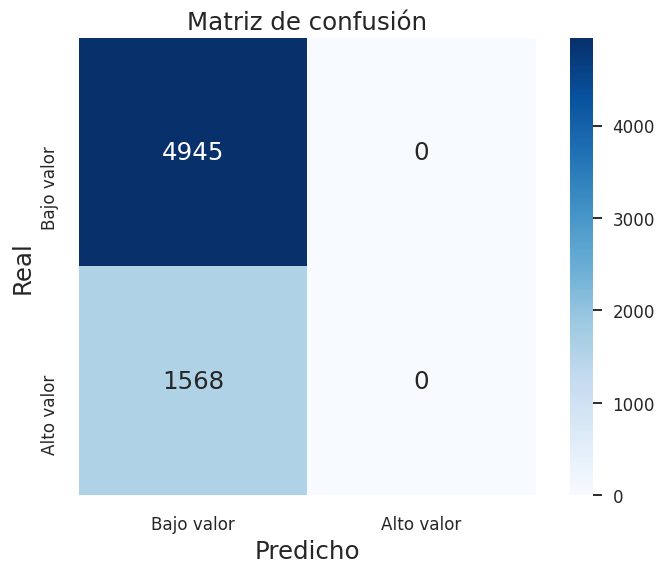

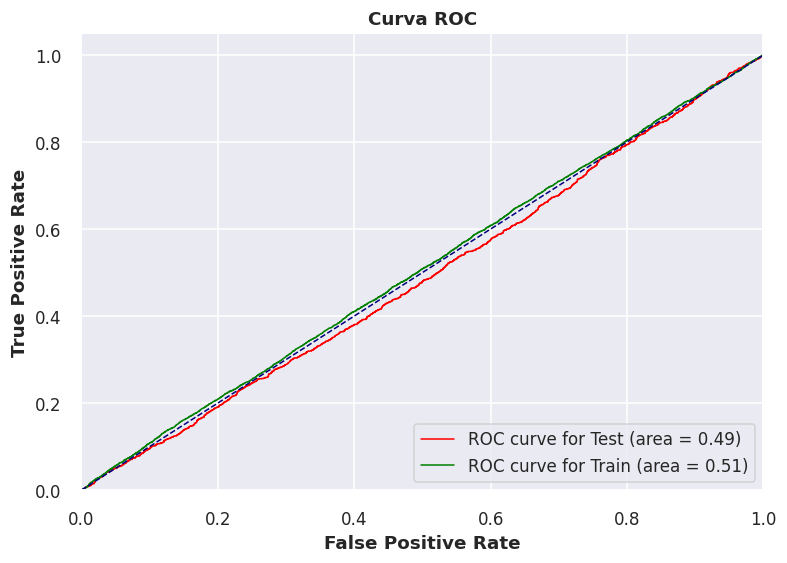

In [35]:
X_df_new = pd.DataFrame(np.vstack((X_test_assemble, X_train_assemble)))
X_train, X_test, y_train, y_test = train_test_split(X_df_new, y_df, test_size=0.20, random_state=0, stratify=y_df)

params = {
        'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07],
}

clf = GaussianNB()
cv = StratifiedKFold(n_splits=20).split(X_train, y_train)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv, n_jobs = -1, verbose=4)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf, X_test, y_test, X_train, y_train)


Es decir, nos dió peor que un modelo RANDOM.

## Primer Preprocesamiento directo

Para esto, entonces hagamos un split con 'train_test_split' tal como veniamos haciendo, manteniendo el mismo random_state pero solamente usaremos el *y_test* e *y_train* que nos dará el split, pues el *X_train* como *X_test* seran el del ensamble. Ademas respeteamos el split puesto que en cada modelo que usamos para el ensamble realizamos el mismo split.

Fitting 20 folds for each of 7 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.4s finished


AUC-ROC score sobre test:  0.8716001655970780
AUC-ROC score sobre train:  0.8723260384087442
Accuracy sobre test:  0.7968678028558268
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
              precision    recall  f1-score   support

  Bajo valor       0.81      0.91      0.86      4406
  Alto valor       0.75      0.56      0.64      2107

    accuracy                           0.80      6513
   macro avg       0.78      0.73      0.75      6513
weighted avg       0.79      0.80      0.79      6513



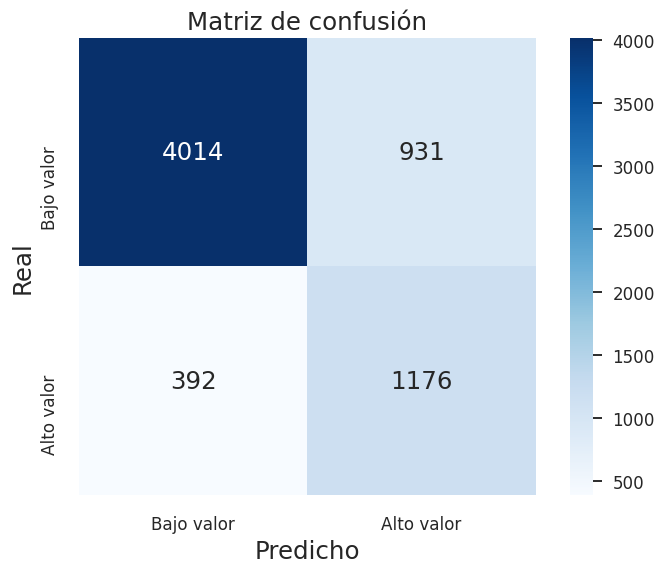

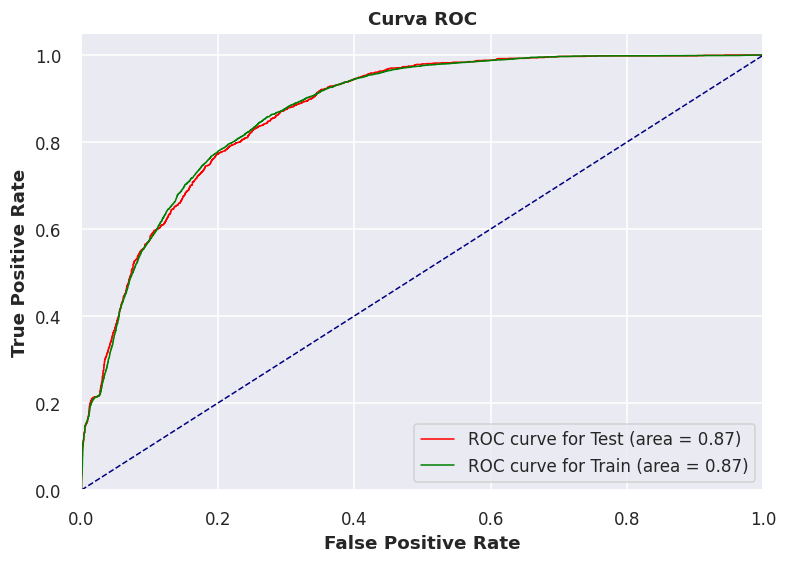

In [36]:
X_train_s, X_test_s, y_train, y_test = train_test_split(X_df, y_df, test_size=0.20, random_state=10, stratify=y_df)
X_train, X_test = X_train_assemble, X_test_assemble

params = {
        'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07],
}

clf = GaussianNB()
cv = StratifiedKFold(n_splits=20).split(X_train, y_train)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv, n_jobs = -1, verbose=4)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf, X_test, y_test, X_train, y_train)


Lo cual se puede observar una mejora increible con un ensamble en comparacion a haber trabajo individualmente cada modelo.

## Segundo Preprocesamiento: get_dataframe_polynomial_all()

In [37]:
def auc_roc_polynomial_ensamble(clf_r, XX_train, XX_test, XX_df, yy_df, grade, interaction_only, params):
    X_train, X_test, y_train, y_test = train_test_split(XX_df, yy_df, test_size=0.20, random_state=10, stratify=y_df)        
        
    X_train = get_dataframe_polynomial_all(XX_train, grade, interaction_only)
    X_test = get_dataframe_polynomial_all(XX_test, grade, interaction_only)

    cv_e = StratifiedKFold(n_splits=10).split(X_train, y_train)
    clf = GridSearchCV(clf_r, params, scoring='roc_auc', cv=cv_e, n_jobs = -1)
        
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(" AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
    print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
    '''
    print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
    print("Los mejores hiperpametros elegidos: ", clf.best_params_)
    print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
    graficar_matriz_confusion(y_test, y_pred)
    plot_roc_curves(clf, X_test, y_test, X_train, y_train)
    '''

* Grado 2, True

In [38]:
X_train, X_test = pd.DataFrame(X_train_assemble), pd.DataFrame(X_test_assemble)
params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
auc_roc_polynomial_ensamble(GaussianNB(), X_train, X_test, X_df, y_df, 2, True, params)

Dataset inicial con 6 features...
Dataset nuevo con PolynomialFeature con 21 features...
Dataset inicial con 6 features...
Dataset nuevo con PolynomialFeature con 21 features...
 AUC-ROC score sobre test:  0.8778851808670890
AUC-ROC score sobre train:  0.8796976910053178


* Grado 2, False

In [39]:
X_train, X_test = pd.DataFrame(X_train_assemble), pd.DataFrame(X_test_assemble)
params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
auc_roc_polynomial_ensamble(GaussianNB(), X_train, X_test, X_df, y_df, 2, False, params)

Dataset inicial con 6 features...
Dataset nuevo con PolynomialFeature con 27 features...
Dataset inicial con 6 features...
Dataset nuevo con PolynomialFeature con 27 features...
 AUC-ROC score sobre test:  0.8759013691421969
AUC-ROC score sobre train:  0.8771675732671658


* Grado 3, True

In [40]:
X_train, X_test = pd.DataFrame(X_train_assemble), pd.DataFrame(X_test_assemble)
params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
auc_roc_polynomial_ensamble(GaussianNB(), X_train, X_test, X_df, y_df, 3, True, params)

Dataset inicial con 6 features...
Dataset nuevo con PolynomialFeature con 41 features...
Dataset inicial con 6 features...
Dataset nuevo con PolynomialFeature con 41 features...
 AUC-ROC score sobre test:  0.8799140674975754
AUC-ROC score sobre train:  0.8824389115312288


* Grado 3, False

In [41]:
X_train, X_test = pd.DataFrame(X_train_assemble), pd.DataFrame(X_test_assemble)
params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
auc_roc_polynomial_ensamble(GaussianNB(), X_train, X_test, X_df, y_df, 3, False, params)

Dataset inicial con 6 features...
Dataset nuevo con PolynomialFeature con 83 features...
Dataset inicial con 6 features...
Dataset nuevo con PolynomialFeature con 83 features...
 AUC-ROC score sobre test:  0.8633422365407235
AUC-ROC score sobre train:  0.8663442889206909


## Tercer Preprocesamiento: Scalers

In [42]:
def auc_scaler_ensamble(clf_r, XX_train, XX_test, XX_df, yy_df, params):
    scalers = [StandardScaler(), MinMaxScaler(), RobustScaler(), PowerTransformer(), Normalizer()]
    for count, scaler in enumerate(scalers):
        print("---------------------------------------------------------------------")
        print("Aplicando preprocesamiento #",count+1, "con scaler de", scaler)
        X_train, X_test, y_train, y_test = train_test_split(XX_df, yy_df, test_size=0.20, random_state=10, stratify=y_df)        
        X_train = get_dataframe_scaled(XX_train, scaler)
        X_test = get_dataframe_scaled(XX_test, scaler)
        
        cv_e = StratifiedKFold(n_splits=10).split(X_train, y_train)
        clf = GridSearchCV(clf_r, params, scoring='roc_auc', cv=cv_e, n_jobs = -1)
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        print(" AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
        print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
        print("Los mejores hiperpametros elegidos: ", clf.best_params_)
        '''
        print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
        graficar_matriz_confusion(y_test, y_pred)
        print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
        plot_roc_curves(clf, X_test, y_test, X_train, y_train)
        '''

  

In [43]:
X_train, X_test = pd.DataFrame(X_train_assemble), pd.DataFrame(X_test_assemble)
params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
auc_scaler_ensamble(GaussianNB(), X_train, X_test, X_df, y_df, params)

---------------------------------------------------------------------
Aplicando preprocesamiento # 1 con scaler de StandardScaler()
 AUC-ROC score sobre test:  0.8715783052351376
AUC-ROC score sobre train:  0.8723258771815799
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
---------------------------------------------------------------------
Aplicando preprocesamiento # 2 con scaler de MinMaxScaler()
 AUC-ROC score sobre test:  0.8716004235364521
AUC-ROC score sobre train:  0.8723260384087442
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
---------------------------------------------------------------------
Aplicando preprocesamiento # 3 con scaler de RobustScaler()
 AUC-ROC score sobre test:  0.8716482068054725
AUC-ROC score sobre train:  0.8723258771815799
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
---------------------------------------------------------------------
Aplicando preprocesamiento # 4 con scaler de PowerTransformer()
 AUC-R

## Eligiendo al mejor: get_dataframe_polynomial_all()

Dataset inicial con 6 features...
Dataset nuevo con PolynomialFeature con 41 features...
Dataset inicial con 6 features...
Dataset nuevo con PolynomialFeature con 41 features...
 AUC-ROC score sobre test:  0.8799140674975754
AUC-ROC score sobre train:  0.8824389115312288
Accuracy sobre test:  0.7856594503301090
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-07}
              precision    recall  f1-score   support

  Bajo valor       0.78      0.93      0.85      4147
  Alto valor       0.81      0.54      0.65      2366

    accuracy                           0.79      6513
   macro avg       0.79      0.73      0.75      6513
weighted avg       0.79      0.79      0.77      6513



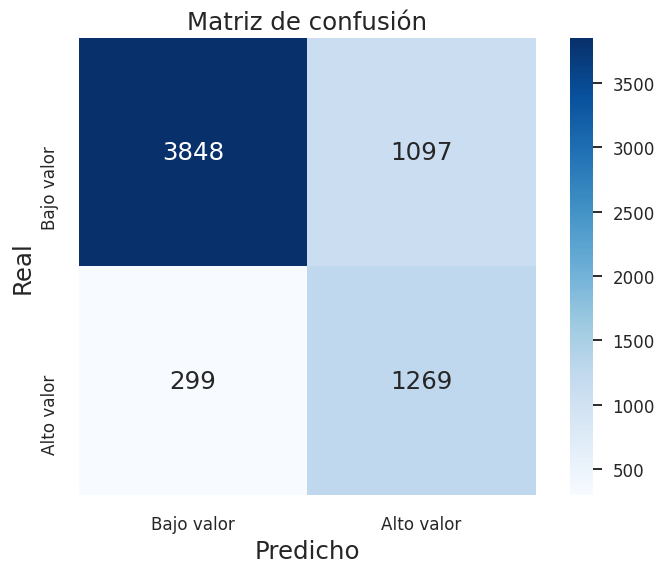

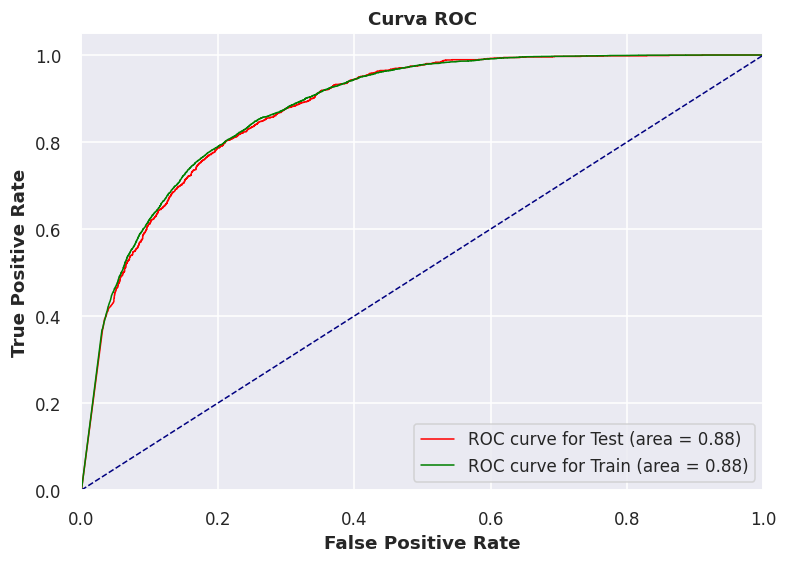

In [44]:
params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
X_train_s, X_test, y_train_s, y_test = train_test_split(X_df, y_df, test_size=0.20, random_state=10, stratify=y_df)        
X_train, X_test = pd.DataFrame(X_train_assemble), pd.DataFrame(X_test_assemble)
X_train = get_dataframe_polynomial_all(X_train, 3, True)
X_test = get_dataframe_polynomial_all(X_test, 3, True)

cv_e = StratifiedKFold(n_splits=10).split(X_train, y_train)
clf = GridSearchCV(GaussianNB(), params, scoring='roc_auc', cv=cv_e, n_jobs = -1)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print(" AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf, X_test, y_test, X_train, y_train)
